In [3]:
%matplotlib inline

In [4]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, learning_curve, validation_curve

In [5]:
df = pd.read_csv("~/projects/us-education-datasets-unification-project/data/us-education-datasets-unification-project/states_all.csv")

In [6]:
df.shape

(1492, 25)

In [7]:
np.sqrt(df.shape[0])
df.shape[0]/50
print('Years/state', len(df)/50)
print('YEARs', df['YEAR'].min(), '--' , df['YEAR'].max())
print('\nSTATEs\n', df['STATE'].unique(), '\n')
print('Features:\n', df.columns.tolist(), '\n')

Years/state 29.84
YEARs 1992 -- 2017

STATEs
 ['ALABAMA' 'ALASKA' 'ARIZONA' 'ARKANSAS' 'CALIFORNIA' 'COLORADO'
 'CONNECTICUT' 'DELAWARE' 'DISTRICT_OF_COLUMBIA' 'FLORIDA' 'GEORGIA'
 'HAWAII' 'IDAHO' 'ILLINOIS' 'INDIANA' 'IOWA' 'KANSAS' 'KENTUCKY'
 'LOUISIANA' 'MAINE' 'MARYLAND' 'MASSACHUSETTS' 'MICHIGAN' 'MINNESOTA'
 'MISSISSIPPI' 'MISSOURI' 'MONTANA' 'NEBRASKA' 'NEVADA' 'NEW_HAMPSHIRE'
 'NEW_JERSEY' 'NEW_MEXICO' 'NEW_YORK' 'NORTH_CAROLINA' 'NORTH_DAKOTA'
 'OHIO' 'OKLAHOMA' 'OREGON' 'PENNSYLVANIA' 'RHODE_ISLAND' 'SOUTH_CAROLINA'
 'SOUTH_DAKOTA' 'TENNESSEE' 'TEXAS' 'UTAH' 'VERMONT' 'VIRGINIA'
 'WASHINGTON' 'WEST_VIRGINIA' 'WISCONSIN' 'WYOMING' 'AMERICAN_SAMOA'
 'BUREAU_OF_INDIAN_AFFAIRS' 'DOD_DOMESTIC' 'DOD_OVERSEAS' 'GUAM'
 'NORTHERN_MARIANAS' 'PUERTO_RICO' 'VIRGIN_ISLANDS' 'BI' 'DD'
 'NORTHERN_MARIANA_ISLANDS' 'DEPARTMENT_OF_DEFENSE'
 'BUREAU_OF_INDIAN_EDUCATION' 'DEPARTMENT_OF_DEFENSE_EDUCATION_ACTIVITY'
 'U.S._VIRGIN_ISLANDS' 'DOD_(OVERSEAS_AND_DOMESTIC_COMBINED)' 'BIE'
 'COMMONWEALT

In [8]:
df.head(5)

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN


In [9]:
df.describe()

,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
count,1492.000000,1.229000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.229000e+03,...,1361.000000,1361.000000,1361.00000,1.361000e+03,1.361000e+03,1.319000e+03,536.000000,532.000000,533.000000,498.000000
mean,2004.433646,9.159308e+05,9.092082e+06,7.663723e+05,4.216553e+06,4.109157e+06,9.196681e+06,4.762966e+06,2.680331e+06,4.292046e+05,...,64538.927259,64271.057311,54268.92432,5.192140e+05,2.470714e+05,8.024415e+05,234.768293,278.414711,218.866154,263.661132
std,7.393983,1.065280e+06,1.174519e+07,1.145242e+06,5.543072e+06,5.482971e+06,1.197813e+07,6.293004e+06,3.353349e+06,5.340693e+05,...,80293.387625,78910.545776,67889.27623,6.436384e+05,3.077056e+05,9.707031e+05,10.221511,10.159722,7.769616,6.803725
min,1992.000000,4.386600e+04,4.656500e+05,3.102000e+04,0.000000e+00,2.209300e+04,4.816650e+05,2.655490e+05,1.399630e+05,1.154100e+04,...,633.000000,437.000000,311.00000,4.878000e+03,1.808000e+03,7.254000e+03,187.134670,232.831510,178.557612,236.379102
25%,1998.000000,2.583140e+05,2.186305e+06,1.893540e+05,1.153097e+06,7.158345e+05,2.165404e+06,1.168032e+06,6.357900e+05,1.028310e+05,...,13739.000000,13342.000000,10919.00000,1.106260e+05,5.147100e+04,1.810650e+05,229.694352,272.761598,214.663401,259.533171
50%,2004.000000,6.483130e+05,5.079546e+06,4.033765e+05,2.537074e+06,2.055780e+06,5.234506e+06,2.657452e+06,1.525406e+06,2.715960e+05,...,43272.000000,43339.000000,36735.00000,3.457750e+05,1.642600e+05,5.503420e+05,237.238552,280.618803,220.416034,265.010912
75%,2011.000000,1.014528e+06,1.085985e+07,8.289660e+05,5.080939e+06,4.768680e+06,1.074519e+07,5.568028e+06,3.229651e+06,5.186000e+05,...,75481.000000,76566.000000,67460.00000,6.119050e+05,2.905020e+05,9.282755e+05,241.995486,285.347428,223.999337,268.190121
max,2017.000000,6.307022e+06,8.921726e+07,9.990221e+06,5.090457e+07,3.610526e+07,8.532013e+07,4.396452e+07,2.605802e+07,3.995951e+06,...,493415.000000,500143.000000,498403.00000,3.929869e+06,2.013687e+06,5.944746e+06,253.420961,300.568235,236.773867,280.499130


In [10]:
set(df[df['AVG_MATH_4_SCORE']>0]['YEAR'].subtract(1).tolist())

{1991, 1995, 1999, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016}

(23, 23)


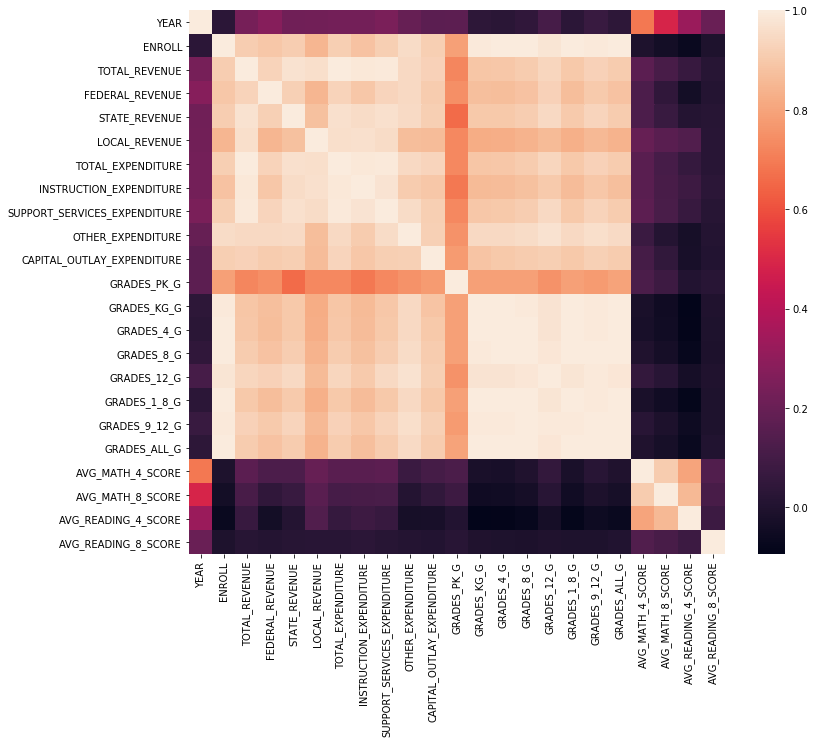

In [11]:
#plt.figure(figsize=(15,15))
corr = df.corr()
print(corr.shape)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr)

In [12]:
# sns.pairplot(df)

In [13]:
# PCA

from sklearn.decomposition import PCA
pca = PCA()
print(pca)

print(df.shape)
print(df.dropna(axis=0).shape)

df1 = df.dropna(axis=0)
df1 = pd.get_dummies(df1, columns=['STATE'])
drop_cols = ['PRIMARY_KEY', 'YEAR', 'ENROLL', \
             'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', \
             'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', \
             'CAPITAL_OUTLAY_EXPENDITURE', \
             'GRADES_PK_G', 'GRADES_KG_G', 'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', \
             'GRADES_1_8_G', 'GRADES_9_12_G', 'GRADES_ALL_G']
df1 = df1.drop(drop_cols, axis=1)
df1 = df1.drop('AVG_MATH_4_SCORE', axis=1)
pca.fit(df1)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
(1492, 25)
(413, 25)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Text(0, 0.5, 'Explained Variance')

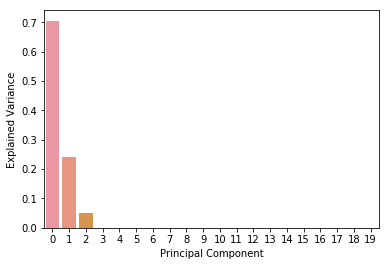

In [14]:
ax = sns.barplot(x=np.arange(20), y=pca.explained_variance_[0:20]/sum(pca.explained_variance_[0:20]))
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')

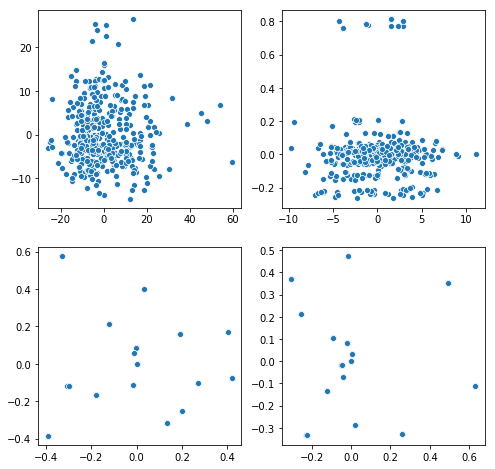

In [15]:
X_pca = pca.fit(df1).transform(df1)
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
sns.scatterplot(X_pca[:,0], X_pca[:,1])
plt.subplot(2,2,2)
sns.scatterplot(X_pca[:,2], X_pca[:,3])
plt.subplot(2,2,3)
sns.scatterplot(X_pca[:,4], X_pca[:,5])
plt.subplot(2,2,4)
sns.scatterplot(X_pca[:,6], X_pca[:,7])

In [16]:
X_pca_df = pd.DataFrame(X_pca)
print(X_pca_df.shape)
print(df.shape)
X_pca_df.head(5)

(413, 54)
(1492, 25)


,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,23.571524,1.784596,-7.054729,-0.243378,-1.212814e-01,2.152192e-01,-4.345837e-02,-7.110527e-02,3.366180e-02,1.048736e-01,...,2.971782e-16,-9.736713e-16,-1.155702e-14,-8.437576e-16,5.757654e-15,-1.064386e-15,-0.029130,0.000845,-0.026965,-1.092591e-16
1,16.997771,-1.303508,3.099418,-0.123219,-1.590266e-02,-1.142258e-01,3.750142e-03,3.396099e-02,1.684512e-02,1.633815e-01,...,2.434017e-16,-3.665181e-16,1.661489e-14,2.439140e-16,1.381814e-15,7.792960e-17,0.003047,0.160101,-0.033734,1.763242e-18
2,19.852474,-9.767561,-3.024893,-0.146795,-9.121913e-04,8.322984e-02,-2.282784e-02,8.382454e-02,-4.181189e-02,4.780973e-02,...,7.915743e-16,-1.479429e-16,4.913402e-14,1.034948e-15,-3.494404e-16,5.364347e-17,0.020388,0.003369,-0.112199,-2.599233e-17
3,23.343371,-7.784619,3.309397,-0.088741,1.298310e-18,-2.737616e-16,-3.686777e-15,2.660320e-15,-9.921324e-16,-1.472343e-15,...,-7.037573e-16,-5.070307e-16,4.134191e-17,5.995323e-16,-5.090350e-16,-3.107023e-15,0.062406,0.017595,-0.069523,-1.092591e-16
4,1.355439,-4.462846,-4.506652,0.010422,-1.625872e-15,1.257999e-15,5.788283e-15,1.492851e-15,-4.301985e-15,1.417706e-15,...,-3.637515e-16,1.278781e-16,1.956477e-15,2.369751e-16,-5.229128e-16,1.999136e-15,0.066994,0.147651,-0.071759,-9.538127e-17


In [17]:
# sns.pairplot(X_pca_df)

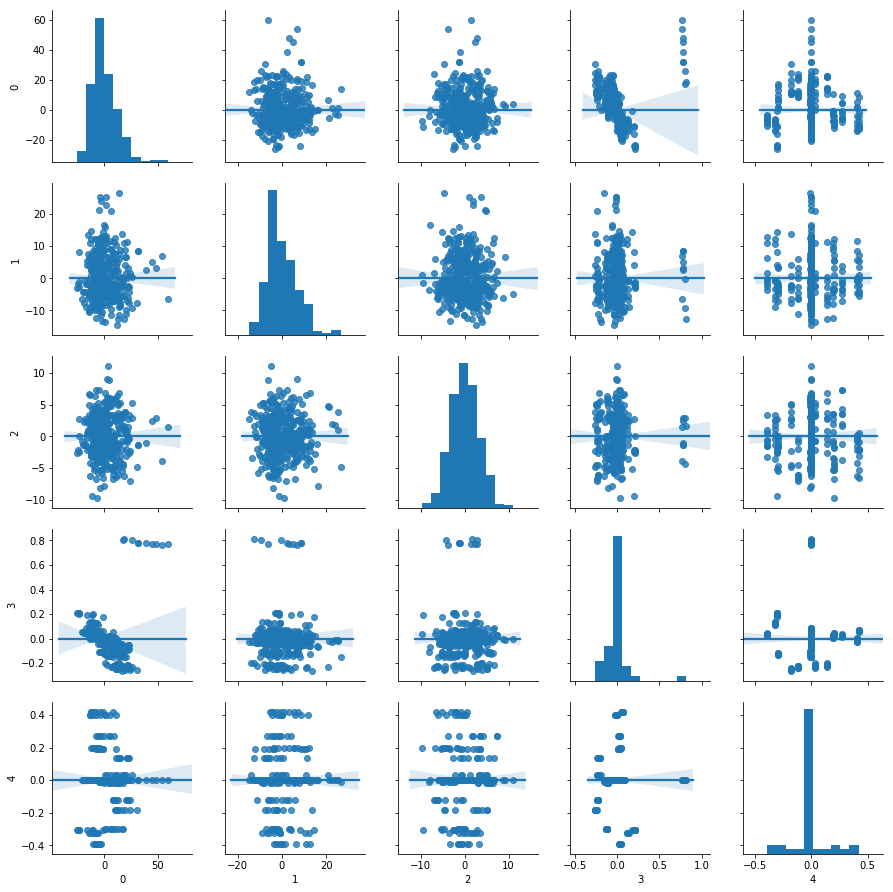

In [18]:
sns.pairplot(X_pca_df.iloc[:,0:5], kind='reg')

In [19]:
shift_cols= ['PRIMARY_KEY', 'YEAR', 'STATE', 'AVG_MATH_4_SCORE']


In [30]:
# Function to return most recent test result
def most_recent_test(cur_yr, state, df, new_cols):
    most_recent_value= pd.DataFrame(data=None, index=new_cols)
    print(most_recent_value)
    df_scratch= df # .copy()
    df_scratch= df_scratch[df_scratch['STATE']==state]
    df_scratch= df_scratch[df_scratch['YEAR']<cur_yr]
    df_scratch.sort_values(by='YEAR')
    
    for new_col in new_cols:
        df_scratch2= df_scratch[df_scratch[new_col].notna()]
        if df_scratch2.notna().any().any(): 
            most_recent_value[new_col]= df_scratch2[new_col].iloc[-1]
        else:
            most_recent_value[new_col]= np.nan #Should handle these cases better
    return most_recent_value

In [39]:
print(df['YEAR'].iloc[-1])

most_recent_test(2009, 'NEVADA', df, ['AVG_MATH_4_SCORE', 'YEAR', 'AVG_MATH_8_SCORE', 'ENROLL'])


2017
Empty DataFrame
Columns: []
Index: [AVG_MATH_4_SCORE, YEAR, AVG_MATH_8_SCORE, ENROLL]


,AVG_MATH_4_SCORE,YEAR,AVG_MATH_8_SCORE,ENROLL
AVG_MATH_4_SCORE,231.781601,2008,270.804024,428776.0
YEAR,231.781601,2008,270.804024,428776.0
AVG_MATH_8_SCORE,231.781601,2008,270.804024,428776.0
ENROLL,231.781601,2008,270.804024,428776.0


In [38]:
# Add recent_ features

cols_add_recent = ['AVG_MATH_4_SCORE', 'AVG_READING_8_SCORE']
for cols in cols_add_recent: 
    df['recent_{}'.format(cols)] = np.zeros(len(df))

for index, data in df.iterrows(): 
    recent_test= most_recent_test(cur_yr=data['YEAR'], state=data['STATE'], df=df, new_cols=cols_add_recent)
    data['recent_{}'.format(i)] for i in cols_add_recent = recent_test[cols]
print('recent_ features added')


SyntaxError: invalid syntax (<ipython-input-38-d60d0454fe06>, line 9)

In [ ]:
# Add recent_AVG_MATH_4_SCORE
df['recent_AVG_MATH_4_SCORE'] = np.zeros(len(df))
#new_cols= ['']
for index, data in df.iterrows(): 
    recent_test= most_recent_test(cur_yr=data['YEAR'], state=data['STATE'], df=df)
    df.loc[index, 'recent_AVG_MATH_4_SCORE']= recent_test
print('recent_AVG_MATH_4_SCORE added')


In [ ]:
# Function to return most recent test result
def most_recent_test(cur_yr, state, df):
    df_scratch= df # .copy()
    df_scratch= df_scratch[df_scratch['STATE']==state]
    df_scratch= df_scratch[df_scratch['YEAR']<cur_yr]
    df_scratch.sort_values(by='YEAR')

    df_scratch2= df_scratch[df_scratch['AVG_MATH_4_SCORE'].notna()]
    if df_scratch2.notna().any().any(): 
        most_recent_value= df_scratch2['AVG_MATH_4_SCORE'].iloc[-1]
    else:
        most_recent_value= np.nan #Should handle these cases better
    return most_recent_value

In [ ]:
most_recent_test(2009, 'VIRGINIA', df)

In [ ]:
#most_recent_test(2009, 'VIRGINIA', df, ['AVG_MATH_4_SCORE', 'YEAR'])

In [ ]:
df[df['STATE']=='VIRGINIA'][df['YEAR'] <1997][['YEAR', 'AVG_MATH_4_SCORE']]

In [ ]:
"""Failed attempts to make new recent_AVG_MATH_4_SCORE

shift_cols= ['PRIMARY_KEY', 'YEAR', 'STATE', 'AVG_MATH_4_SCORE']
df_shift= df[shift_cols].copy()
# print(df.shape, df_shift.shape)

year= df_shift['YEAR']
df_shift.loc['YEAR']= year-1
df_shift['YEAR'] = df_shift['YEAR'].astype(int)

df_shift.loc['PRIMARY_KEY']= "{}_{}".format(df_shift['YEAR'], df_shift['STATE'])
df_join= df.join(df_shift, on='PRIMARY_KEY', rsuffix='_shift')
"""

'''
print(df_join.shape)
print(df_shift['AVG_MATH_4_SCORE'].notna().sum())
print(df_join['AVG_MATH_4_SCORE_shift'].notna().sum())
print(df_join['AVG_MATH_4_SCORE'].notna().sum())

print(df_join['STATE_shift'].notna().sum())

print(df_shift['PRIMARY_KEY'])
'''

# df_join['recent_AVG_MATH_4_SCORE'] = df_join['AVG_MATH_4_SCORE_shift']
# df_join= df_join.drop(labels=['PRIMARY_KEY_shift', 'YEAR_shift', 'STATE_shift', 'AVG_MATH_4_SCORE_shift'], axis=1)

# print(df_join.shape, '\n', df_join)
# print(df_join['recent_AVG_MATH_4_SCORE'])
# print(df_join['AVG_MATH_4_SCORE'])

In [ ]:
print(np.count_nonzero(~np.isnan(df['recent_AVG_MATH_4_SCORE'])))
print(np.shape(df['recent_AVG_MATH_4_SCORE']))

# print(df['recent_AVG_MATH_4_SCORE'].value_counts())

In [ ]:
"""print(key, lag_key)
print(df[df['PRIMARY_KEY']==key]['GRADES_12_G'])
print()
print(df[df['PRIMARY_KEY']==lag_key]['GRADES_8_G'])
"""

In [ ]:
#Normalize expenditures to fraction of total expenditures
expenditure_cols = ['INSTRUCTION_EXPENDITURE',
 'SUPPORT_SERVICES_EXPENDITURE',
 'OTHER_EXPENDITURE',
 'CAPITAL_OUTLAY_EXPENDITURE']

for col in expenditure_cols:
    df['fracn_exp_{}'.format(col)] = df[col] / df['TOTAL_EXPENDITURE']
    #df=df.drop(col, axis=1)
    print('fracn_exp_{}'.format(col))

In [ ]:
#Normalize revenue to fraction of total revenue
revenue_cols = ['FEDERAL_REVENUE',
 'STATE_REVENUE',
 'LOCAL_REVENUE']

for col in revenue_cols:
    df['fracn_rev_{}'.format(col)] = df[col] / df['TOTAL_REVENUE']
    #df=df.drop(col, axis=1)
    print('fracn_rev_{}'.format(col))

In [ ]:
#Normalize students enrolled to fraction of enrolled population
fracn_enroll_cols = ['GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G']

for col in fracn_enroll_cols:
    df['fracn_enroll_{}'.format(col)] = df[col] / df['GRADES_ALL_G']
    print('fracn_enroll_{}'.format(col))
    #df = df.drop(col, axis=1) 

In [ ]:
df['avg_total_revenue']=df['TOTAL_REVENUE']/df['GRADES_ALL_G']
df['avg_total_expenditure'] = df['TOTAL_EXPENDITURE'] / df['GRADES_ALL_G']

df['fracn_schoolage'] = df['GRADES_ALL_G']/df['ENROLL']
df['rev_per_person'] = df['TOTAL_REVENUE'] / df['ENROLL']
df['exp_per_rev'] = df['TOTAL_EXPENDITURE'] / df['TOTAL_REVENUE']

#Models want to know about drop-out rate
df['fracn_GRADES_12div8_G'] = np.zeros(len(df))
#Subtract take ratio GRADES_12_G(YEAR)/GRADES_8_G(YEAR-4)
for state in set(df['STATE'].tolist()):
    for year in set(df['YEAR'].tolist()):
        key= "{}_{}".format(year, state)
        lag_year = year-4
        lag_key= "{}_{}".format(lag_year, state)
        if np.any(df['PRIMARY_KEY']==lag_key):
            df.loc[df['PRIMARY_KEY']==key, ['fracn_GRADES_12div8_G']]= np.divide( \
                df[df['PRIMARY_KEY']==key]['GRADES_12_G'], np.median(df[df['PRIMARY_KEY']==lag_key]['GRADES_8_G']))

In [ ]:
print(df.shape)
print(np.count_nonzero(df['fracn_GRADES_12div8_G'].notna()))
df['fracn_GRADES_12div8_G'].describe()

In [ ]:
df.describe()

In [ ]:
#sns.pairplot(df, kind='scatter')

In [ ]:
#plt.figure(figsize=(15,15))
corr = df.corr()
print(corr.shape)
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr)

In [ ]:
# KMeans Clustering

from sklearn.cluster import KMeans
# df.drop(['AVG_MATH_4_SCORE'], axis=1)
print(df.shape)
print(df.dropna(axis=0).shape)

df1 = df.dropna(axis=0)
df1 = pd.get_dummies(df1, columns=['STATE'])
drop_cols = ['PRIMARY_KEY', 'YEAR', 'ENROLL', \
             'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', \
             'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', \
             'CAPITAL_OUTLAY_EXPENDITURE', \
             'GRADES_PK_G', 'GRADES_KG_G', 'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', \
             'GRADES_1_8_G', 'GRADES_9_12_G', 'GRADES_ALL_G']
df1 = df1.drop(drop_cols, axis=1)

kmeans = KMeans(n_clusters=10)
y_pred = kmeans.fit_predict(df1)

In [ ]:
print(df1.columns)

In [ ]:
kmeans.cluster_centers_
centers = pd.DataFrame(data=kmeans.cluster_centers_, columns=df1.columns)
centers.sort_values('AVG_MATH_4_SCORE')

In [ ]:
centers['AVG_MATH_4_SCORE']

In [ ]:
centers.describe()

In [ ]:
print(y_pred)

In [ ]:
sns.scatterplot('avg_total_revenue', 'AVG_MATH_4_SCORE' , hue=y_pred.astype(np.int), data=df1, \
                legend='full', palette="Paired", bac)

In [ ]:
# Affinity Propagation Clustering

from sklearn.cluster import AffinityPropagation
# df.drop(['AVG_MATH_4_SCORE'], axis=1)
print(df.shape)
print(df.dropna(axis=0).shape)

df1 = df.dropna(axis=0)
df1 = pd.get_dummies(df1, columns=['STATE'])
drop_cols = ['PRIMARY_KEY', 'YEAR', 'ENROLL', \
             'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', \
             'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', \
             'CAPITAL_OUTLAY_EXPENDITURE', \
             'GRADES_PK_G', 'GRADES_KG_G', 'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', \
             'GRADES_1_8_G', 'GRADES_9_12_G', 'GRADES_ALL_G']
df1 = df1.drop(drop_cols, axis=1)

aff_prop = AffinityPropagation()
y_aff_prop = aff_prop.fit_predict(df1)

In [ ]:
aff_prop.cluster_centers_
centers = pd.DataFrame(data=aff_prop.cluster_centers_, columns=df1.columns)
centers.sort_values('AVG_MATH_4_SCORE')

In [ ]:
sns.scatterplot('avg_total_revenue', 'AVG_MATH_4_SCORE' , hue=y_aff_prop.astype(np.int), data=df1, \
                legend='full', palette="Paired")

In [ ]:
# PCA

from sklearn.decomposition import PCA
pca = PCA()
print(pca)

print(df.shape)
print(df.dropna(axis=0).shape)

df1 = df.dropna(axis=0)
df1 = pd.get_dummies(df1, columns=['STATE'])
drop_cols = ['PRIMARY_KEY', 'YEAR', 'ENROLL', \
             'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', \
             'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', \
             'CAPITAL_OUTLAY_EXPENDITURE', \
             'GRADES_PK_G', 'GRADES_KG_G', 'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', \
             'GRADES_1_8_G', 'GRADES_9_12_G', 'GRADES_ALL_G']
df1 = df1.drop(drop_cols, axis=1)
df1 = df1.drop('AVG_MATH_4_SCORE', axis=1)
pca.fit(df1)

In [ ]:
ax = sns.barplot(x=np.arange(20), y=pca.explained_variance_[0:20]/sum(pca.explained_variance_[0:20]))
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')

In [ ]:
X_pca = pca.fit(df1).transform(df1)
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
sns.scatterplot(X_pca[:,0], X_pca[:,1])
plt.subplot(2,2,2)
sns.scatterplot(X_pca[:,2], X_pca[:,3])
plt.subplot(2,2,3)
sns.scatterplot(X_pca[:,4], X_pca[:,5])
plt.subplot(2,2,4)
sns.scatterplot(X_pca[:,6], X_pca[:,7])

In [ ]:
kill script

In [ ]:
g = sns.FacetGrid(df, row="STATE") 
g.map(plt.scatter, 'YEAR', 'AVG_MATH_4_SCORE')

In [ ]:
sns.lmplot(x="YEAR", y="AVG_MATH_4_SCORE", hue="STATE", data=df.dropna(), legend_out=True);

In [ ]:
plt.hist('avg_total_expenditure', bins=50, log=True, data=df);

In [ ]:
#For some reason VIRGINIA has 3 entries for 2008 and 2 of them have increicbly high avg_instruction_expenditure
df[df['avg_total_expenditure'] > 100]

In [ ]:
df['AVG_MATH_4_SCORE'].dropna().hist(density=True, cumulative=True)
plt.show()
df['AVG_MATH_4_SCORE'].dropna().hist()

In [ ]:
sns.jointplot("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")
sns.jointplot("YEAR", "AVG_READING_4_SCORE", data=df, kind="reg")

In [ ]:
sns.jointplot("avg_total_revenue", "AVG_READING_4_SCORE", data=df, kind="reg")

In [ ]:
sns.jointplot("avg_total_expenditure", "AVG_MATH_4_SCORE", data=df, kind="reg")

In [ ]:
sns.jointplot("AVG_READING_4_SCORE", "AVG_MATH_4_SCORE", data=df, kind="reg")

In [ ]:
sns.jointplot("AVG_MATH_8_SCORE", "AVG_MATH_4_SCORE", data=df, kind="reg")

In [ ]:
df1=df.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
print(df1.columns)
df1 = pd.get_dummies(df1, columns=['STATE'])

y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns

ts_cv = TimeSeriesSplit(n_splits=5)
print(ts_cv)
for train_index, test_index in ts_cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

"""
PredefinedSplit won't work because it folds in future data

test_fold = df1.loc[:,'YEAR'].values
ps = PredefinedSplit(test_fold)
print(ps.get_n_splits())
for train_index, test_index in ps.split():
    print("Train:", train_index, "Test:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
"""

In [ ]:
n_splits=20
ts_cv = TimeSeriesSplit(n_splits=n_splits)
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1)

index=0
train_score = np.zeros(n_splits)
test_score = np.zeros(n_splits)

for train_index, test_index in ts_cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]   
    
    rf_model.fit(X_train, y_train) 
    Y_rf=rf_model.predict(X_test)
    train_score[index]=rf_model.score(X_train,y_train) #Train score
    test_score[index]=rf_model.score(X_test,y_test) #Test score
    index+=1
index_list=np.arange(index)

In [ ]:
print(index)
print(index_list)
print(train_score)
print(test_score)

In [ ]:
plt.plot(index_list,train_score,'o', label="Train")
plt.plot(index_list,test_score,'o', label="Test")
plt.xlabel("Split")
plt.ylabel("R^2 Score")
plt.legend(loc="best")

In [ ]:
model=RandomForestRegressor()

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

"""
param_search = [
  {'n_estimators': [1, 10, 20, 100]}
]
gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
gsrch_rf_model.fit(X,y)
"""

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[4,5,6,7,8,9,10,20,30,40,50,60]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="n_estimators", param_range=param_range, cv=ts_cv, n_jobs=-1)

In [ ]:
train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.plot(param_range,train_scores_mean,'o',label="Train")
plt.plot(param_range,test_scores_mean,'o',label="Test")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.title("Validation Curves")
plt.legend(loc="best")

In [ ]:
model=RandomForestRegressor(n_estimators=20)

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=30), cv=ts_cv, n_jobs=-1)

In [ ]:
plt.figure()
plt.plot(train_sizes, -train_scores.mean(1), 'o-', color="g",
         label="Train")
plt.plot(train_sizes, -test_scores.mean(1), 'o-', color="r",
         label="Test")
plt.xlabel("Train Size")
plt.ylabel("Score")
plt.title("Learning Curves")
plt.legend(loc="best")

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)  

In [ ]:
Y_rf=rf_model.predict(X)
plt.plot(Y_rf, y, 'ro')
plt.show()

In [ ]:
rf_model.score(X,y)

In [ ]:
feature_importances_rf = pd.DataFrame(rf_model.feature_importances_, index = df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns, columns=['importance']).sort_values('importance',ascending=False)
feature_importances_rf.head(10)

In [ ]:
sns.jointplot(x='YEAR', y='AVG_MATH_4_SCORE', data=df, kind='reg')
sns.jointplot(x='fracn_enroll_GRADES_12_G', y='AVG_MATH_4_SCORE', data=df, kind='reg')
sns.jointplot(x='fracn_rev_FEDERAL_REVENUE', y='AVG_MATH_4_SCORE', data=df, kind='reg')

In [ ]:
from sklearn import svm
svm_model = svm.SVR(gamma='scale')
svm_model.fit(X, y)  

In [ ]:
Y_svm=svm_model.predict(X)
plt.plot(Y_svm, y, 'ro')
plt.show()

# Lasso

In [ ]:
model=linear_model.Lasso(normalize=True)
param_search = [
  {'alpha': [0.00001,0.0001,0.001,0.01,0.1,1]}
 ]

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

#gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
#gsrch_rf_model.fit(X,y)

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[0.00001,0.0001,0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.5,1]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="alpha", param_range=param_range, cv=ts_cv, n_jobs=-1)

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.semilogx(param_range,train_scores_mean,'o',label="Train")
plt.semilogx(param_range,test_scores_mean,'o',label="Test")
plt.semilogx(param_range,test_scores_mean,label="Test_curve")
plt.xlabel("alpha")
plt.ylabel("Score")
plt.title("Validation Curves")
plt.legend(loc="best")

In [ ]:
model=linear_model.Lasso(alpha=0.01, normalize=True)
#lasso_model.fit(X, y)  
#Y_lasso=lasso_model.predict(X)

num_splits=5
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=30), cv=ts_cv, n_jobs=-1)

print(train_sizes.shape,train_scores.shape, test_scores.shape)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes,train_scores_mean,'o',label="Train")
plt.plot(train_sizes,test_scores_mean,'o',label="Test")
plt.xlabel("Train Sizes")
plt.ylabel("Score")
plt.title("Learning Curves")
plt.legend(loc="best")

In [ ]:
"""Plot test data fit"""

In [ ]:

lasso_model=linear_model.Lasso(alpha=0.01, normalize=True)
lasso_model.fit(X, y)  
Y_lasso=lasso_model.predict(X)
plt.plot(Y_lasso, y, 'ro')

# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(Y_lasso,y)
line = slope*Y_lasso+intercept

plt.plot(Y_lasso,y,'o',Y_lasso,line,Y_lasso,Y_lasso)
plt.legend(("y","fit_lasso","y=x"),loc='best')
plt.xlabel("Y_lasso")
plt.ylabel("y")

In [ ]:
lasso_coef_ = lasso_model.coef_
print(X_cols.shape)
#print(X_cols)
print(lasso_coef_.shape)
print(np.round(lasso_coef_))
#print(lasso_coef_)
X_cols[np.abs(lasso_coef_)>10]

sorted(zip(lasso_coef_.round(), X_cols))

In [ ]:
scaler=StandardScaler()
X_transformed = scaler.fit_transform(X)

model=linear_model.Lasso(alpha=0.01, normalize=True)
lasso_model.fit(X_transformed, y)  
Y_lasso=lasso_model.predict(X_transformed)

lasso_coef_ = lasso_model.coef_
print(X_cols.shape)
#print(X_cols)
print(lasso_coef_.shape)
print(np.round(lasso_coef_))
#print(lasso_coef_)
X_cols[np.abs(lasso_coef_)>10]

sorted(zip(lasso_coef_, X_cols))

In [ ]:
"""fracn_GRADES_12div8_G
is not chosen by Lasso. RandomForest says it's #2 tho. Why?
Plot.
"""
plt.figure(figsize=[7,7])
x1=df1.loc[:,'fracn_GRADES_12div8_G'].values
plt.plot(x1,y,'o')
plt.plot(x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("fracn_GRADES_12div8_G")
plt.ylabel("y")

In [ ]:
plt.figure(figsize=[20,10])

plt.subplot(2, 2, 1)
x1=df1.loc[:,'fracn_enroll_GRADES_12_G'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("fracn_enroll_GRADES_12_G")
plt.ylabel("y")

plt.subplot(2, 2, 2)
x1=df1.loc[:,'fracn_enroll_GRADES_9_12_G'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("fracn_enroll_GRADES_9_12_G")
plt.ylabel("y")

plt.subplot(2, 2, 3)
x1=df1.loc[:,'YEAR'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("YEAR")
plt.ylabel("y")

plt.subplot(2, 2, 4)
x1=df1.loc[:,'STATE_DISTRICT_OF_COLUMBIA'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("STATE_DISTRICT_OF_COLUMBIA")
plt.ylabel("y")

In [ ]:
plt.figure(figsize=[15,10])

plt.subplot(2, 2, 1)
plt.plot(Y_lasso,y,'o',Y_lasso,line,Y_lasso,Y_lasso)
plt.legend(("y","fit_lasso","y=x"),loc='best')
plt.xlabel("Y_lasso")
plt.ylabel("y")

In [ ]:
# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(Y_lasso,y)
line = slope*Y_lasso+intercept

#need to make analysis_df that has y,Y_lasso

#Plot
#grid=sns.JointGrid(x=Y_lasso,y=y)
#g=grid.plot_joint(sns.scatterplot) #, hue='smoker'
#sns.scatterplot(Y_lasso,line, ax=g.ax_marg_x, legend=False)
#sns.lmplot(Y_lasso,Y_lasso,ax=g.ax_marg_x,legend=False)

#plt.subplot(1,2,1)
ax1 = sns.jointplot(x=Y_lasso,y=y,kind="kde")
#plt.subplot(1,2,2)
ax2 = sns.jointplot(x=Y_lasso,y=y,kind="resid")

In [ ]:
"""The largest coefficients are"""
X_cols[np.abs(lasso_coef_)>0.5]
""". Plot them with fits."""

plt.plot(Y_svm, y, 'ro')("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")
sns.jointplot("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")


In [ ]:
"""
Can I predict test scores for a year?

Handle time better. Time_series_split

Time trends: 
-Scores
-Populations
-Revenues
-Expenditures

Delta from previous time point as feature?

Features:
-Elite? financials, location, 
-Good school? school history, tax rev, district
-Trends in time? Deltas in time. more money, more students, higher scores, ...


"""